In [36]:
import boto3
import pandas as pd
import time

In [2]:
athena_client = boto3.client('athena', region_name='us-east-1')

In [42]:
# Query Execution
query = """SELECT
    httprequest.country,
    COUNT(*) AS cantidad
FROM 
    waf_access_logs
GROUP BY
    httprequest.country
ORDER BY cantidad DESC
LIMIT 10"""

response = athena_client.start_query_execution(
    QueryString=query,
    QueryExecutionContext={
        'Database': 'glueaccesslogsdatabase-duzex3xzallx'
    },
    ResultConfiguration={
        'OutputLocation': 's3://strengthen-template-athenaoutputlocation-bg4sr3tmokfe'
    }
)

In [44]:
# Query Results
query_execution_id = response['QueryExecutionId']
query_status = athena_client.get_query_execution(QueryExecutionId=query_execution_id)
if query_status['QueryExecution']['Status']['State'] == 'SUCCEEDED':
    results_paginator = athena_client.get_paginator('get_query_results')
    results_iter = results_paginator.paginate(
        QueryExecutionId=query_execution_id,
        PaginationConfig={'PageSize': 1000}
    )
    results_list = []
    for results in results_iter:
        for row in results['ResultSet']['Rows']:
            results_list.append(row['Data'])
else:
    time.sleep(3)
    print('Query still running, please rerun this cell to see results')


In [45]:
df = pd.DataFrame(results_list)
cols_name = [col['VarCharValue'] for col in df.iloc[0]]
df.columns = cols_name
for col in cols_name:
    df[col] = df[col].apply(lambda x: x['VarCharValue'])
df.drop(0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [46]:
df

,country,cantidad
0,US,42673
1,UY,145
2,FR,106
3,NL,28
4,DE,25
5,PT,14
6,SG,14
7,IN,14
8,AU,13
9,GB,13


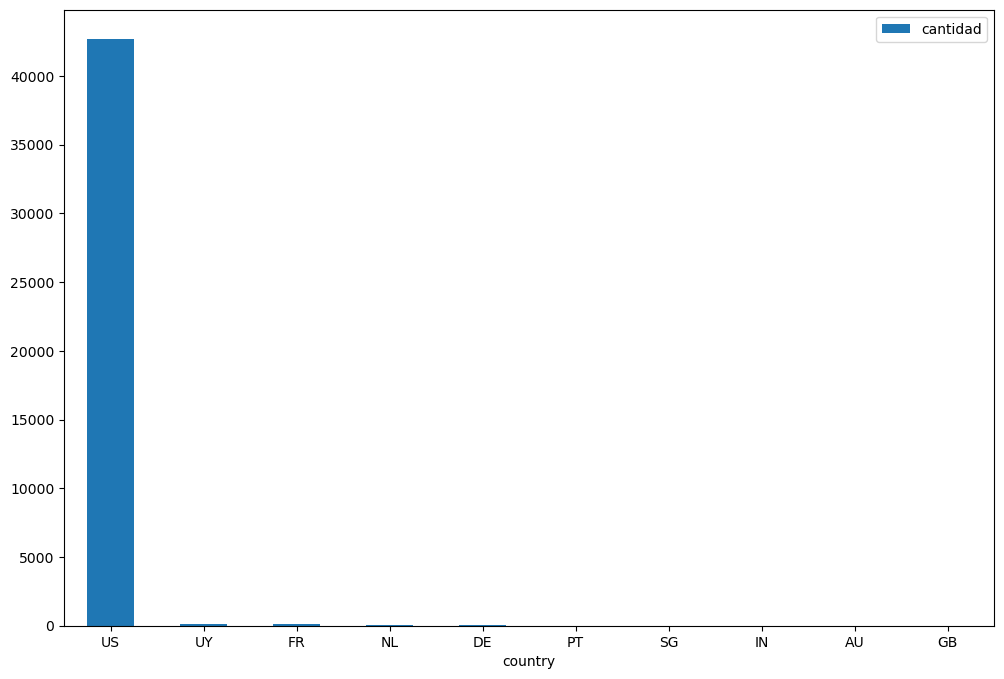

In [48]:
# Plot log results
df.cantidad = df.cantidad.astype(int)
df.plot.bar(x='country', y='cantidad', rot=0, figsize=(12, 8));